In [1]:
!pip install implicit
!pip install lightfm
!pip install scikit-learn
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k
from lightfm.cross_validation import random_train_test_split
import scipy.sparse as sp
from implicit.als import AlternatingLeastSquares
from google.colab import files
from scipy.sparse import coo_matrix, csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import identity
# from google.colab import drive
# drive.mount ('/content/drive')

In [3]:
data= pd.read_csv('/content/my_dataframe.csv')

In [4]:
data.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

In [6]:
# data.drop(columns=['Churn','Customer Name'],axis=1, inplace=True)
# data

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

**Number of products that was not returened?**

In [8]:
# 500000 - 405022

**Number of Items sold in the store?**

In [9]:
data['Item Purchased'].nunique()

25

In [10]:
data['Item Purchased'].unique()

array(['Blouse', 'Sweater', 'Jeans', 'Sandals', 'Sneakers', 'Shirt',
       'Shorts', 'Coat', 'Handbag', 'Shoes', 'Dress', 'Skirt',
       'Sunglasses', 'Pants', 'Jacket', 'Hoodie', 'Jewelry', 'T-shirt',
       'Scarf', 'Hat', 'Socks', 'Backpack', 'Belt', 'Boots', 'Gloves'],
      dtype=object)

Unique customer count on dataset

In [11]:
data['Customer ID'].nunique()

3900

Most bought Items by gender

In [12]:
grouped_data = data.groupby(['Gender', 'Item Purchased']).size().reset_index(name='Count')


most_purchased_item = grouped_data.loc[grouped_data.groupby('Gender')['Count'].idxmax()]

# Display the result
most_purchased_item

,Gender,Item Purchased,Count
2,Female,Blouse,66
38,Male,Pants,123


Total number of each item sold

In [13]:
# Function to find the total number of each product sold
def most_Sold_Product(data):
  product_Sum = {} # declared empty dictionary to store the total sum of each product
  # The below checks if a product is in the dataframe column 'Item Purchased' exists and finds all it's occurrences in the 'Previous Purchases' column and sum them up
  for name_Of_Product in data['Item Purchased'].unique(): # for every unique product in the column Item Purchased
    total_prod = data[data['Item Purchased'] == name_Of_Product]['Previous Purchases'].sum() # Filter based on the product name and sum all the quantities (in the Previous Purchases column) of the filtered product.
    product_Sum[name_Of_Product] = int(total_prod) #assigns the sum of each product to the empty dictionary created earlier and we convert the total to integer because we want to apply the f-string and it doesn't work on numpy

  #sort the products based on most sold to the least sold
  sorted_product_Sum = sorted(product_Sum.items(), key=lambda x: x[1], reverse=True)

  # Print sum total of products on the dataset
  for name_Of_Product, total_prod in sorted_product_Sum:
    total_prod = f"{total_prod:,}"  # Formats the number with commas
    print('Total', name_Of_Product, 'sold:', total_prod)
  return sorted_product_Sum
# Call the the function to print totals of each sold product from most sold to least sold
sorted_product_Sum = most_Sold_Product(data)

Total Jewelry sold: 4,943
Total Blouse sold: 4,563
Total Dress sold: 4,407
Total Shirt sold: 4,338
Total Coat sold: 4,317
Total Pants sold: 4,302
Total Scarf sold: 4,205
Total Sweater sold: 4,199
Total Sunglasses sold: 4,121
Total Shorts sold: 4,088
Total Socks sold: 3,965
Total Skirt sold: 3,925
Total Hat sold: 3,901
Total Belt sold: 3,877
Total Sandals sold: 3,869
Total Boots sold: 3,796
Total Shoes sold: 3,790
Total Handbag sold: 3,781
Total Jacket sold: 3,769
Total Gloves sold: 3,702
Total Hoodie sold: 3,673
Total Sneakers sold: 3,659
Total T-shirt sold: 3,648
Total Backpack sold: 3,370
Total Jeans sold: 2,663


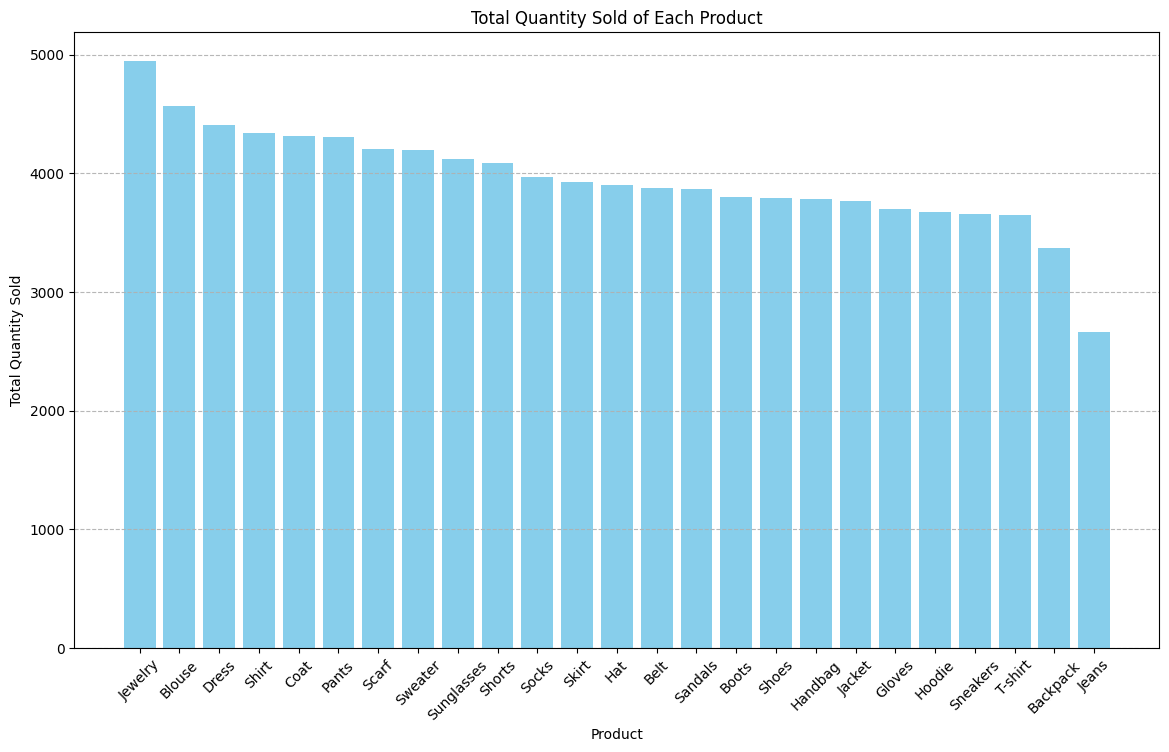

In [14]:
# Extract product names and total quantities
product_names = [item[0] for item in sorted_product_Sum]
total_quantities = [item[1] for item in sorted_product_Sum]

# Plotting the bar chart
plt.figure(figsize=(14, 8))
plt.bar(product_names, total_quantities, color='skyblue')

# Adding titles and labels
plt.title('Total Quantity Sold of Each Product')
plt.xlabel('Product')
plt.ylabel('Total Quantity Sold')

# Grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.9)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

Finding the number of unique years that make up the datset

In [15]:
# # Listing all unique years on the dataset
# data['Purchase Date'] = pd.to_datetime(data['Purchase Date'], dayfirst=True, format='mixed') # Convert 'Purchase Date' to datetime
# data['Purchase Date'].dt.year.unique()

How much revenue was made each year?

In [16]:
# # Total purchase by Year
# By_Year = data.groupby(data['Purchase Date'].dt.year)['Total Purchase Amount'].sum()
# By_Year.apply(lambda x: f'{x:,}') # applied f-string using lambda function to make the values easily readable

In [17]:
# # Plotting the bar chart
# plt.figure(figsize=(10, 6))
# By_Year.plot(kind='bar', color='skyblue')

# # Titles and labels
# plt.title('Total Purchase Amount by Year')
# plt.xlabel('Year')
# plt.ylabel('Total Purchase Amount')

# # Grid for better readability
# plt.grid(axis='y', linestyle='--', alpha=0.9)

# # Show the plot
# plt.show()

In [18]:
# # Total Purchase for the 4 years
# f'{By_Year.sum():,}' # applied f-string using lambda function to make the values easily readable

Years and Months with most and least sales

In [19]:
# """
# The 'Purchase Date' will be parsed with "pd.to_datetime()" to extract the months correctly because of the inconsistencies
# in the date formate (e.g., 3/5/2023 21:30 versus 16/05/2021 13:57) of our data.

# """
# # Using the 'dayfirst' parameter and set 'format' to 'mixed' to handle inconsistent date formats in our data
# data['Purchase Date'] = pd.to_datetime(data['Purchase Date'], dayfirst=True, format='mixed')

# # Group by both year and month, and sum the 'Total Purchase Amount'
# by_month_year = data.groupby([data['Purchase Date'].dt.year, data['Purchase Date'].dt.month])['Total Purchase Amount'].sum()

# # Find the year and month with the highest total purchase amount
# year_month_with_highest_purchase = by_month_year.idxmax()
# highest_purchase_amount = by_month_year.max()

# # Find the year and month with the lowest total purchase amount
# year_month_with_lowest_purchase = by_month_year.idxmin()
# lowest_purchase_amount = by_month_year.min()

# # Extract year and month from the index for output
# high_year, high_month = year_month_with_highest_purchase
# low_year, low_month = year_month_with_lowest_purchase

# print(f"Year and month with highest purchase amount: {high_year}-{high_month:02d}, Amount: £{highest_purchase_amount:,}")
# print('''
# ===========================================
# ===========================================
# ''')
# print(f"Year and month with lowest purchase amount: {low_year}-{low_month:02d}, Amount: £{lowest_purchase_amount:,}")


In [20]:

# # Create the bar chart
# fig, ax = plt.subplots(figsize=(12, 6))

# # Plot total purchase amounts by year and month
# bars = by_month_year.plot(kind='bar', color='skyblue', ax=ax)

# # Highlight the bars with the highest and lowest purchase amounts
# highlight_color = 'coral'
# highlight_idx = [by_month_year.index.get_loc((high_year, high_month)), by_month_year.index.get_loc((low_year, low_month))]
# for i in highlight_idx:
#     bars.patches[i].set_facecolor(highlight_color)

# # Format the x-axis labels to show year-month
# ax.set_xticks(range(len(by_month_year)))
# ax.set_xticklabels([f"{year}-{month:02d}" for year, month in by_month_year.index], rotation=45, ha='right')

# # Add labels and title
# ax.set_xlabel('Year-Month')
# ax.set_ylabel('Total Purchase Amount (£)')
# ax.set_title('Total Purchase Amount by Year and Month')

# # Add annotations for highest and lowest
# for idx, (year_month, amount) in enumerate([((high_year, high_month), highest_purchase_amount), ((low_year, low_month), lowest_purchase_amount)]):
#     ax.annotate(f'{"Highest" if idx == 0 else "Lowest"}\n£{amount:,}',
#                 xy=(by_month_year.index.get_loc(year_month), amount),
#                 xytext=(by_month_year.index.get_loc(year_month), amount + 500),
#                 arrowprops=dict(facecolor='black', shrink=0.05),
#                 ha='center')

# plt.tight_layout()
# plt.show()


Dates with the most and least sales

In [21]:

# # Convert 'Purchase Date' to datetime
# data['Purchase Date'] = pd.to_datetime(data['Purchase Date'], dayfirst=True)

# # Group by date (year, month, day) only and sum the 'Total Purchase Amount'
# by_date = data.groupby(data['Purchase Date'].dt.date)['Total Purchase Amount'].sum()

# # Find the date with the highest total purchase amount
# date_with_highest_purchase = by_date.idxmax()
# highest_purchase_amount = by_date.max()

# # Find the date with the lowest total purchase amount
# date_with_lowest_purchase = by_date.idxmin()
# lowest_purchase_amount = by_date.min()

# print(f"Date with highest purchase amount: {date_with_highest_purchase}, Amount: £{highest_purchase_amount:,}")
# print('''
# ===========================================
# ===========================================
# ''')
# print(f"Date with lowest purchase amount: {date_with_lowest_purchase}, Amount: £{lowest_purchase_amount:,}")


Dates and times with the most and least sales

In [22]:
# # Convert 'Purchase Date' to datetime
# data['Purchase Date'] = pd.to_datetime(data['Purchase Date'], dayfirst=True)

# # Group by the full datetime (including time) and sum the 'Total Purchase Amount'
# by_datetime = data.groupby(data['Purchase Date'])['Total Purchase Amount'].sum()

# # Find the datetime with the highest total purchase amount
# datetime_with_highest_purchase = by_datetime.idxmax()
# highest_purchase_amount = by_datetime.max()

# # Find the datetime with the lowest total purchase amount
# datetime_with_lowest_purchase = by_datetime.idxmin()
# lowest_purchase_amount = by_datetime.min()

# print(f"Datetime with highest purchase amount: {datetime_with_highest_purchase}, Amount: £{highest_purchase_amount:,}")
# print('''
# ===========================================
# ===========================================
# ''')
# print(f"Datetime with lowest purchase amount: {datetime_with_lowest_purchase}, Amount: £{lowest_purchase_amount:,}")


**Average Price spent per age group**

In [23]:
# Average of Total purchase by Age
Ave_purchase_by_age = data.groupby('Age')['Purchase Amount (USD)'].mean().sort_values(ascending= True)
Ave_purchase_by_age.head(20)

,Purchase Amount (USD)
Age,
48,52.588235
27,53.734940
42,54.462500
20,55.225806
34,55.279412
58,55.814815
40,55.916667
47,56.605634
45,56.736111


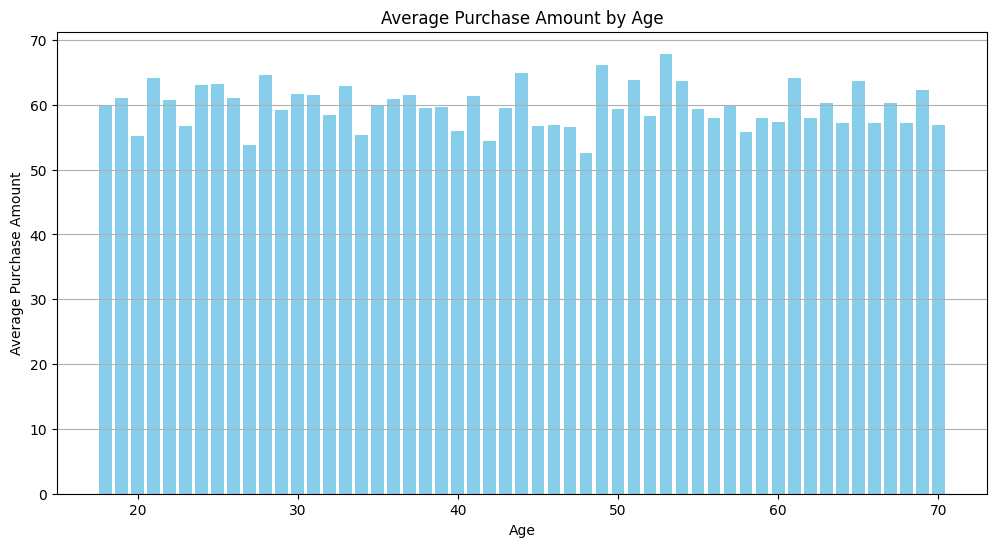

In [24]:
# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(Ave_purchase_by_age.index, Ave_purchase_by_age.values, color='skyblue')

# Titles and labels
plt.title('Average Purchase Amount by Age')
plt.xlabel('Age')
plt.ylabel('Average Purchase Amount')

# Adding grid for better readability
plt.grid(True, axis='y')

# Show the plot
plt.show()

**Total expenses by age**

In [25]:
Sum_expenses_per_age = data.groupby('Age')['Purchase Amount (USD)'].sum().sort_values(ascending= False)
Sum_expenses_per_age.apply(lambda x: f'{x:,}') # applied f-string using lambda function to make the values easily readable

,Purchase Amount (USD)
Age,
49,"5,552"
69,"5,484"
25,"5,372"
41,"5,282"
54,"5,282"
57,"5,200"
28,"5,104"
19,"4,941"
50,"4,930"


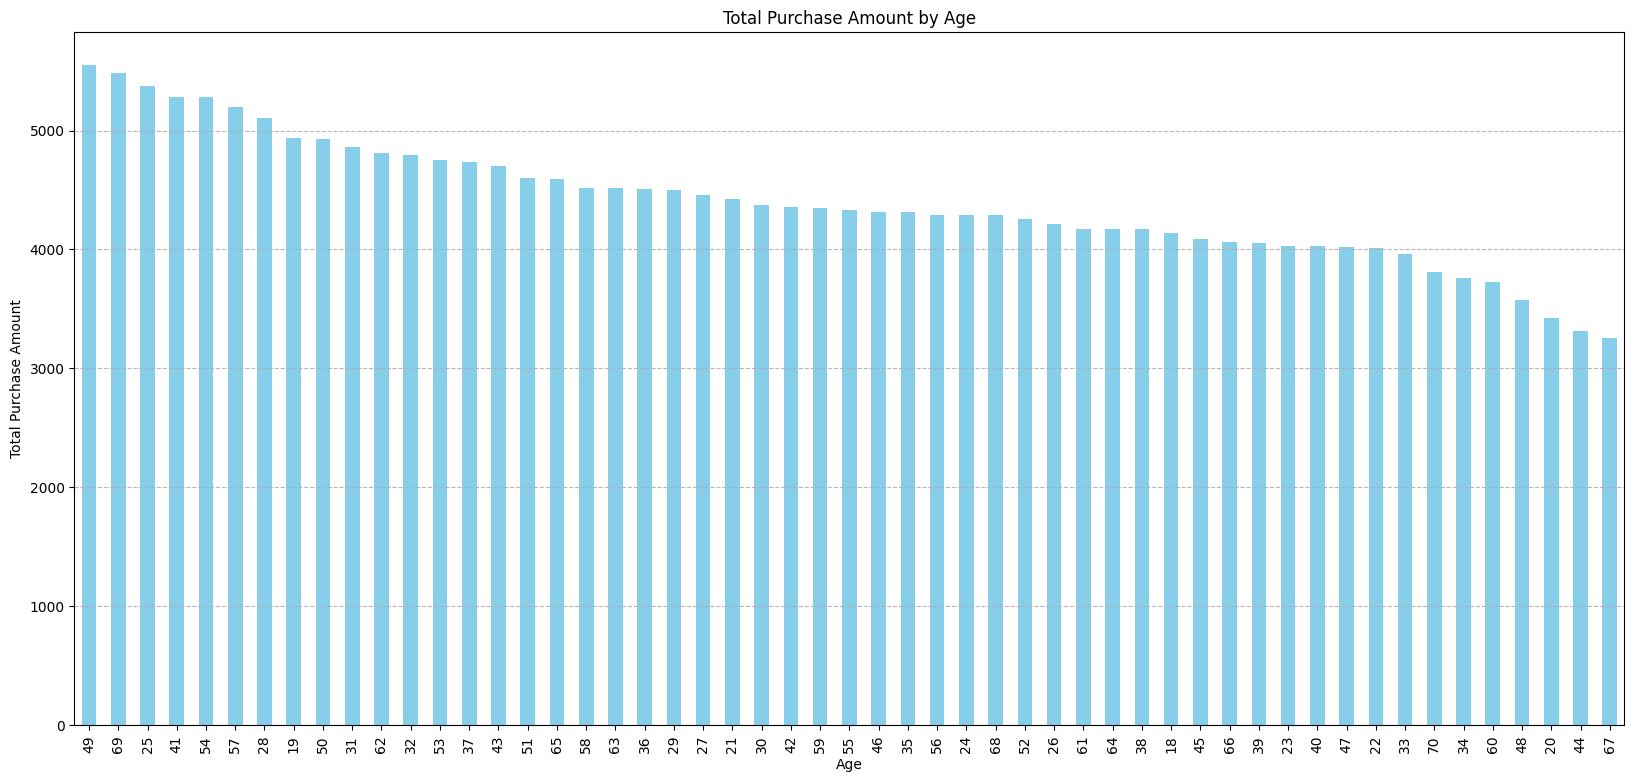

In [26]:
# Plotting the bar chart
plt.figure(figsize=(20, 9))
Sum_expenses_per_age.plot(kind='bar', color='skyblue')

# Titles and labels
plt.title('Total Purchase Amount by Age')
plt.xlabel('Age')
plt.ylabel('Total Purchase Amount')

# Grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.9)

# Show the plot
plt.show()

Total amount spent by gender

In [27]:
# Finding Total purchase per gender
by_gender = data.groupby('Gender')['Purchase Amount (USD)'].sum().sort_values(ascending= False)
by_gender.apply(lambda x: f'{x:,}') # applied f-string using lambda function to make the values easily readable

,Purchase Amount (USD)
Gender,
Male,"157,890"
Female,"75,191"


Average age for both genders

In [28]:
# Average age for both genders
data.groupby('Gender')['Age'].mean()

,Age
Gender,
Female,44.007212
Male,44.097285


To develope a recommendation model without explicit customer ratings, we would use the **Matrix Factorization** techniques **Alternating Least Squares (ALS)**. This is because our data lacks direct feedback, we rely on implicit signals such as product quantities purchased. ALS helps uncover such implicit feedbacks patterns in customer interactions with products.

In [29]:
# #Mapping Customer ID and Item Purcahsed to unique indices
# data['customer_ids'] = data['Customer ID'].astype('category').cat.codes
data['item_ids'] = data['Item Purchased'].astype('category').cat.codes

In [30]:
#Normlising the Previous Purchases ( that is the Quanities purchased) column to prevent it from dominating the entire interaction matrix when combined with rating interactions
data['Quantity_normalised'] = (data['Previous Purchases'] - data['Previous Purchases'].min()) / (data['Previous Purchases'].max() - data['Previous Purchases'].min())

In [31]:
# Normalising the rating interaction too
data['Rating_normalised'] = data['Review Rating'] / 5.0  # As our rating is based of 5 star

In [32]:
# Now combine the normalised interactions

interaction_values = (0.5 * data['Quantity_normalised']) + (1 * data['Rating_normalised']) # We want rating to carry a little more wieght than quantity purchased


**Creating User Features**

In [33]:
# '''
#  We will use the columns Gender, Age and Frequency of Purchase to create user feature
#  First we start by preprocessing and encoding the values of these columns to be used in the model
# '''

# # Step 1: Handle missing values for Gender, Age, and Frequency of Purchases
# # Replace missing gender with most frequent value, fill age and frequency with reasonable defaults
# data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
# # data['Age'].fillna(data['Age'].median(), inplace=True)
# # data['Frequency of Purchases'].fillna(data['Frequency of Purchases'].mode()[0], inplace=True)

# # Step 2: One-hot encoding for 'Gender'
# gender_ohe = pd.get_dummies(data['Gender'], drop_first=True)

# # # Step 3: Bin and encode 'Age'
# # age_bins = [0, 18, 25, 35, 45, 55, 65, 100]
# # age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
# # data['Age_Group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels, right=False)
# # # One-hot encoding for 'Age_Group'
# # age_ohe = pd.get_dummies(data['Age_Group'], drop_first=True)

# # # Step 4: One-hot encoding for 'Frequency of Purchases'
# # frequency_ohe = pd.get_dummies(data['Frequency of Purchases'], prefix='Frequency', drop_first=True)

# # # Step 5: Concatenate all encoded features
# # user_features_df = pd.concat([gender_ohe, age_ohe, frequency_ohe], axis=1)

# # # Step 6: Convert to a sparse matrix for efficient storage
# # user_features = csr_matrix(user_features_df.values)

# '''Delete if experiment doesn't work'''
# user_features = csr_matrix(gender_ohe.values)
# '''delete section if exerimetnt deosn't work'''
# # # Optional: If you want to keep track of the feature names
# # user_feature_names = user_features_df.columns.tolist()

# # Now user_features can be used in your model


**Creating Item Feature**

In [34]:
# '''
# For Items feauture we will use the following columns:
# 1. Category
# 2. Purchase Amount (USD)
# 3. Sizes
# '''

# # Step 1: Handle missing values for Category, Purchase Amount (USD), and Size
# # Replace missing values with defaults (e.g., 'Unknown' for category/size, median for amount)
# data['Category'].fillna('Unknown', inplace=True)
# # data['Purchase Amount (USD)'].fillna(data['Purchase Amount (USD)'].median(), inplace=True)
# data['Size'].fillna('Unknown', inplace=True)

# # Step 2: One-hot encoding for 'Category'
# item_categories_ohe = pd.get_dummies(data['Category'], prefix='Category', drop_first=True)

# # # Step 3: Bin and encode 'Purchase Amount (USD)'
# # amount_bins = [0, 50, 100, 200, 500, float('inf')]  # Adjust the upper bound to cover all values
# # amount_labels = ['Low', 'Medium', 'High', 'Very High', 'Extreme']  # Added 'Extreme' for >500
# # data['Amount_Group'] = pd.cut(data['Purchase Amount (USD)'], bins=amount_bins, labels=amount_labels, right=False)

# # # One-hot encoding for 'Amount_Group'
# # amount_ohe = pd.get_dummies(data['Amount_Group'], prefix='Amount', drop_first=True)

# # Step 4: One-hot encoding for 'Size'
# size_ohe = pd.get_dummies(data['Size'], prefix='Size', drop_first=True)

# # # Step 5: Concatenate all encoded features
# # item_features_df = pd.concat([item_categories_ohe, amount_ohe, size_ohe], axis=1)

# # # Step 6: Convert to sparse matrix for efficient storage
# # item_features = csr_matrix(item_features_df.values)

# '''Delete if experiment doesn't work'''
# item_features_df = pd.concat([item_categories_ohe, size_ohe], axis=1)
# item_features = csr_matrix(item_features_df.values)
# '''delete section if experimetnt deosn't work'''

# # # Optional: Keep track of feature names for future reference
# # item_feature_names = item_features_df.columns.tolist()

In [35]:
# Building the sparse matrix with customer_ids as rows and item_ids as columns
interaction_matrix = coo_matrix((interaction_values, (data['Customer ID'] - 1, data['item_ids'])))
interaction_matrix

<3900x25 sparse matrix of type '<class 'numpy.float64'>'
	with 3900 stored elements in COOrdinate format>

In [36]:
# Split the interaction matrix into train and test sets
train_size = 0.8  # 80% of the data for training
interactions_train, interactions_test = train_test_split(interaction_matrix, train_size=train_size, random_state=42)


In [37]:
''' To fix feauture mismatch issue let's us the shape of the the training
set to create identity matrix (that's user and item feature) that
matches/has the shape of the interactions_train matrix'''

# # Create identity matrices for user and item features (no additional features)
user_features = identity(interactions_train.shape[0], format='csr')
item_features = identity(interactions_train.shape[1], format='csr')

In [38]:
# # Split the user features
# train_size = 0.8  # 80% of the data for training
# user_features_train, user_features_test = train_test_split(user_features, train_size=train_size, random_state=42)

# # Split the item features
# train_size = 0.8  # 80% of the data for training
# item_features_train, item_features_test = train_test_split(item_features, train_size=train_size, random_state=42)

In [39]:

# # Scale user features
# scaler_user = StandardScaler(with_mean=False) # Set with_mean=False for sparse matrices
# user_features_train = scaler_user.fit_transform(user_features_train)
# user_features_test = scaler_user.transform(user_features_test)

# # Scale item features
# scaler_item = StandardScaler(with_mean=False) # Set with_mean=False for sparse matrices
# item_features_train = scaler_item.fit_transform(item_features_train)
# item_features_test = scaler_item.transform(item_features_test)


**Model creation and Training**

In [40]:
#Train LightFM model

# Initialize the LightFM model with the brp loss function
model = LightFM(loss='bpr', learning_rate=0.081, no_components=interaction_matrix.shape[1])

# Train the model using the training set
model.fit(interactions_train, epochs=30, num_threads=4)

**MAKE RECOMMENDATION**

In [41]:
# Created a mapping of item IDs to product names in a pandas DataFrame 'items_df'
# For example, items_df contains 'item_id' and 'product_name' columns

import numpy as np

Customer_ID = 26  # The ID of the user for whom you want to make recommendations

# Get the number of items
n_items = interaction_matrix.shape[1]

# Predict scores for all items for the user
scores = model.predict(Customer_ID, np.arange(n_items))

# Rank items by the score
top_items = np.argsort(-scores)  # Get ranked item IDs

# Filter out the top 5 unique product names and include their scores
unique_top_items_with_scores = []
for item_id in top_items:
    product_name = data.loc[data['item_ids'] == item_id, 'Item Purchased'].values[0]
    score = scores[item_id]

    if product_name not in [item[0] for item in unique_top_items_with_scores]:  # Avoids duplicates
        unique_top_items_with_scores.append((product_name, score))  # Appendname and score fo reach product sorted

    if len(unique_top_items_with_scores) == 5:  # Stop after 5 unique items
        break

# Print the top 5 unique recommended product names with their scores
for product, score in unique_top_items_with_scores:
    print(f"Product: {product}, Score: {score:.4f}")


Product: Backpack, Score: 4.0284
Product: Sneakers, Score: 1.7313
Product: Boots, Score: 1.2957
Product: Blouse, Score: 0.5593
Product: Hat, Score: 0.0541


**EVALUATING THE MODEL**

In [42]:
# from lightfm.evaluation import precision_at_k, recall_at_k

# # Assuming 'interactions' is your interaction matrix
# num_users, num_items = interactions_test.shape



# # Convert user_features and item_features to sparse matrices
# # user_features = csr_matrix(np.zeros((num_users, 3120)))
# # item_features = csr_matrix(np.zeros((num_items, 25)))

# # Evaluate the model on the test data
# test_precision = precision_at_k(model, interactions_test, k=10).mean()
# test_recall = recall_at_k(model, interactions_test, k=10, user_features=user_features, item_features=item_features_test).mean()

# print(f"Test Precision@k: {test_precision}")
# print(f"Test Recall@k: {test_recall}")



In [43]:
# Evaluate the model on the test data, using identity matrices as user/item features
test_precision = precision_at_k(model, interactions_test, k=10, user_features=user_features, item_features=item_features).mean()
test_recall = recall_at_k(model, interactions_test, k=10, user_features=user_features, item_features=item_features).mean()

print(f"Test Precision@k: {test_precision}")
print(f"Test Recall@k: {test_recall}")

Test Precision@k: 0.03987179696559906
Test Recall@k: 0.39871794871794874


In [45]:
!git config --global user.name "TonyNewness"
!git config --global user.email "dubemanthony@gmail.com"

In [50]:
!git clone https://github.com/TonyNewness/Product-Recommendation.git

fatal: destination path 'Product-Recommendation' already exists and is not an empty directory.


In [51]:
!cp LightFM_approach_The_Recommendation_engine.ipynb Product-Recommendation/

cp: cannot stat 'LightFM_approach_The_Recommendation_engine.ipynb': No such file or directory


In [52]:
!ls

my_dataframe.csv  Product-Recommendation  sample_data


In [53]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
!ls

drive  my_dataframe.csv  Product-Recommendation  sample_data


In [57]:
!cp /content/drive/MyDrive/Colab Notebooks/LightFM_approach_The_Recommendation_engine.ipynb Product-Recommendation/

cp: cannot stat '/content/drive/MyDrive/Colab': No such file or directory
cp: cannot stat 'Notebooks/LightFM_approach_The_Recommendation_engine.ipynb': No such file or directory
